In [1]:
import numpy as np
import pandas as pd

In [128]:
data=pd.read_csv('JPX/train_files/stock_prices.csv',parse_dates = ['Date'])
data=data.sort_values("Date")
data.head(4)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053


In [62]:
# data.describe()

In [63]:
data=data[['Date','Open']]


In [64]:
data.rename(columns={"Date":"date"},inplace=True)

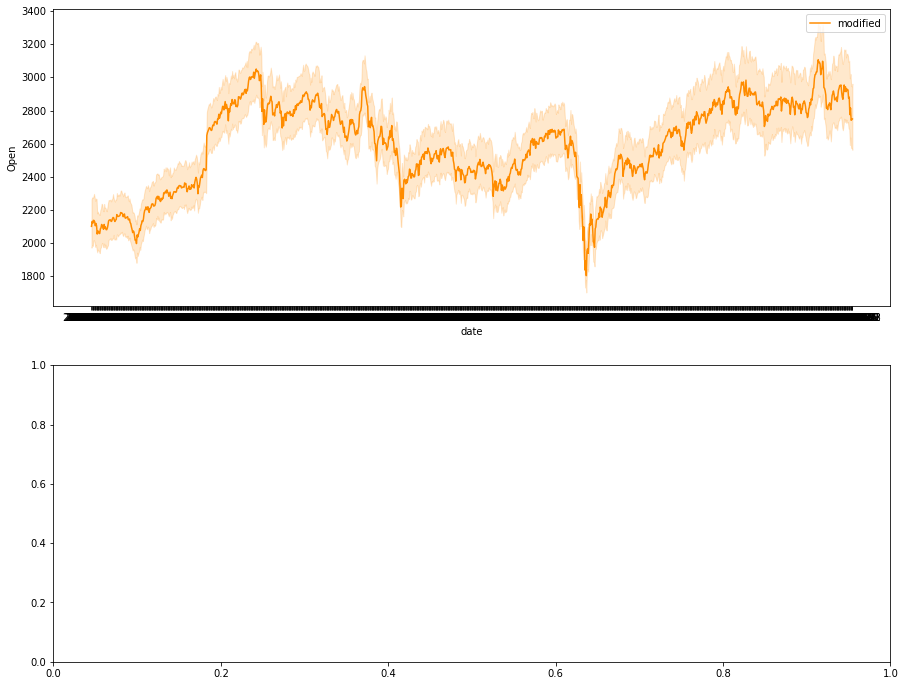

In [27]:
import seaborn as sns # Visualization
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=data['date'], y=data['Open'], ax=ax[0], color='darkorange', label = 'modified')
plt.show()

In [65]:
data.count()


date    2332531
Open    2324923
dtype: int64

In [81]:
print(data.date.min(),data.date.max())
data["date"]=pd.to_datetime(data['date'])
meandf=data.groupby("date").Open.mean().reset_index()


2017-01-04 00:00:00 2021-12-03 00:00:00


In [82]:
type(meandf)

pandas.core.frame.DataFrame

In [85]:
meandf.isna().sum()

date    0
Open    1
dtype: int64

In [89]:
meandf.info

<bound method DataFrame.info of            date         Open
0    2017-01-04  2101.280140
1    2017-01-05  2130.523940
2    2017-01-06  2119.835891
3    2017-01-10  2137.608176
4    2017-01-11  2136.635895
...         ...          ...
1197 2021-11-29  2775.476777
1198 2021-11-30  2815.366449
1199 2021-12-01  2741.466867
1200 2021-12-02  2745.357916
1201 2021-12-03  2749.357845

[1202 rows x 2 columns]>

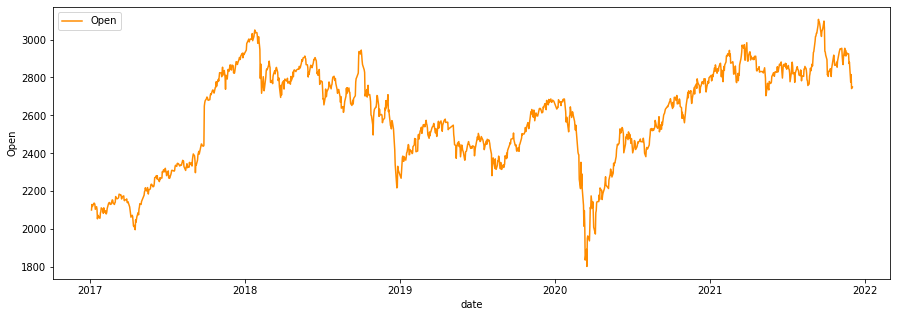

In [97]:
import seaborn as sns # Visualization
import matplotlib.pyplot as plt
f, ax = plt.subplots( figsize=(15, 5))

sns.lineplot(x=meandf['date'], y=meandf['Open'], color='darkorange', label = 'Open')
plt.show()

In [104]:
from statsmodels.tsa.stattools import adfuller
meandf.dropna(inplace=True)
#perform augmented Dickey-Fuller test
res=adfuller(meandf["Open"])
if res[1]>0.05: print("Data is not stationary pvalue:",res[1])
else: print("Data is stationary")

Data is not stationary pvalue: 0.1321390850394631


In [106]:
meandf["OpenLog"]=meandf["Open"].apply(lambda x: np.log(x))
res=adfuller(meandf["OpenLog"])
if res[1]>0.05: print("Data is not stationary pvalue:",res[1])
else: print("Data is stationary")

Data is not stationary pvalue: 0.10653291805091514


In [107]:
meandf["OpenDiff"]=meandf["Open"]-meandf["Open"].shift()
meandf["OpenLogDiff"]=meandf["OpenLog"]-meandf["OpenLog"].shift()

In [109]:
meandf.dropna(inplace=True)

In [113]:
res=adfuller(meandf["OpenLogDiff"])
if res[1]>0.05: print("Data is not stationary pvalue:",res[1])
else: print("Data is stationary pval: ",res[1])

res=adfuller(meandf["OpenDiff"])
if res[1]>0.05: print("Data is not stationary pvalue:",res[1])
else: print("Data is stationary pval: ",res[1])

Data is stationary pval:  4.734227982180905e-14
Data is stationary pval:  1.8656897137577846e-14


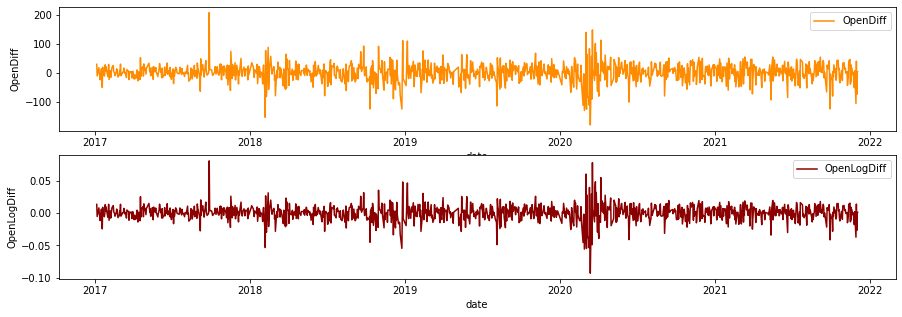

In [112]:
import seaborn as sns # Visualization
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 5))

sns.lineplot(x=meandf['date'], y=meandf['OpenDiff'],ax=ax[0], color='darkorange', label = 'OpenDiff')
sns.lineplot(x=meandf['date'], y=meandf['OpenLogDiff'],ax=ax[1], color='darkred', label = 'OpenLogDiff')

plt.show()

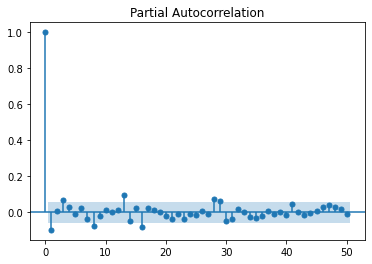

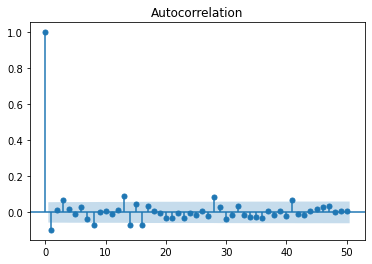

In [117]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(meandf["OpenDiff"], lags=50)
plot_acf(meandf["OpenDiff"], lags=50)

plt.show()

In [118]:
train_size = int(0.85 * len(meandf))
test_size = len(meandf) - train_size

univariate_df = meandf[['date', 'OpenDiff']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

1020 180


In [119]:
from statsmodels.tsa.arima_model import ARIMA

# Fit model
model = ARIMA(y_train, order=(1,0,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred, se, conf = model_fit.forecast(90)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

/Users/krutikasarode/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/krutikasarode/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was p

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86440D+00    |proj g|=  1.12355D-04

At iterate    5    f=  4.86439D+00    |proj g|=  6.87450D-05

At iterate   10    f=  4.86439D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   8.882D-08   4.864D+00
  F =   4.8643946438675032     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


NameError: name 'mean_absolute_error' is not defined

/Users/krutikasarode/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/krutikasarode/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


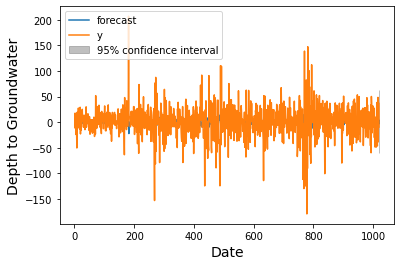

In [125]:
f, ax = plt.subplots(1)
# f.set_figheight(6)
# f.set_figwidth(15)

model_fit.plot_predict(1, 1020, ax=ax)
# sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

# ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

# ax.set_ylim(-35, -18)
plt.show()

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
!pip install fbprophet
from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 4.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.1/197.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 1.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [45 lines of output]
      running b

  Created wheel for pymeeus: filename=PyMeeus-0.5.11-py3-none-any.whl size=730984 sha256=d9b59dea6fc7814a0bdf8d9dbd6edc55a20c85a961bbd694bc194be2403b779b
  Stored in directory: /Users/krutikasarode/Library/Caches/pip/wheels/33/3d/82/4579e9cca41ff991140b2e050bc6df3a38292f26e4fa06b15d
Successfully built pymeeus
Failed to build fbprophet
  Running setup.py install for fbprophet ... error
  error: subprocess-exited-with-error
  
  × Running setup.py install for fbprophet did not run successfully.
  │ exit code: 1
  ╰─> [42 lines of output]
      running install
      running build
      running build_py
      creating build
      creating build/lib
      creating build/lib/fbprophet
      creating build/lib/fbprophet/stan_model
      Importing plotly failed. Interactive plots will not work.
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/bj/r2dj9qf91bv819f05

ModuleNotFoundError: No module named 'fbprophet'

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("eth.csv",parse_dates=["date"])
df.head(3)

,date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2021-10-06,3515.48,3538.70,3502.80,3517.71,3517.71,11513.0,0.0,1.0
1,2021-10-05,3386.31,3545.00,3363.78,3515.27,3515.27,393900.0,0.0,1.0
2,2021-10-04,3417.73,3437.19,3270.00,3386.31,3386.31,485204.0,0.0,1.0


In [3]:
df=df.sort_values("date",ascending=True).reset_index(drop=True)

In [4]:
import datetime
df["date"]=pd.to_datetime(df["date"])
# df.index=df.pop('date')

In [5]:
df["close6"]=df["close"].shift(-6)
df.dropna(inplace=True)
df.head(3)

,date,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient,close6
0,2021-06-29,2084.42,2245.00,2073.57,2165.33,2165.33,831257.0,0.0,1.0,2196.53
1,2021-06-30,2165.46,2287.78,2087.99,2275.68,2275.68,910583.0,0.0,1.0,2322.50
2,2021-07-01,2275.68,2275.93,2073.12,2106.41,2106.41,787865.0,0.0,1.0,2316.57


In [6]:
windowed_df=df[["date","close","close6"]]
windowed_df.head(3)

,date,close,close6
0,2021-06-29,2165.33,2196.53
1,2021-06-30,2275.68,2322.50
2,2021-07-01,2106.41,2316.57


In [7]:
df_np=windowed_df.to_numpy()
dates=df_np[:,0]
middle_matrix=df_np[:,1]
print(middle_matrix.shape)
X=middle_matrix.reshape((len(dates),1,1))
X.astype(np.float32)

Y=df_np[:,-1]
Y.astype(np.float32)

(94,)


array([2196.53, 2322.5 , 2316.57, 2116.33, 2146.99, 2110.69, 2140.45,
       2031.58, 1940.15, 1994.58, 1919.51, 1876.26, 1899.59, 1891.64,
       1818.73, 1786.03, 1995.5 , 2024.56, 2124.25, 2184.75, 2189.79,
       2228.08, 2299.49, 2300.9 , 2382.92, 2461.81, 2531.05, 2555.69,
       2606.93, 2509.04, 2724.78, 2826.99, 2891.58, 3160.31, 3011.85,
       3160.52, 3141.66, 3160.5 , 3045.96, 3322.32, 3263.16, 3307.09,
       3146.53, 3011.72, 3014.55, 3184.12, 3284.82, 3223.43, 3238.  ,
       3321.28, 3170.62, 3226.87, 3093.2 , 3273.45, 3244.48, 3223.47,
       3229.64, 3429.2 , 3826.82, 3785.82, 3938.11, 3885.52, 3950.29,
       3926.77, 3434.57, 3499.  , 3424.93, 3208.86, 3267.21, 3404.21,
       3285.35, 3434.37, 3613.55, 3567.98, 3399.81, 3435.64, 3328.62,
       2977.28, 2765.9 , 3076.92, 3152.5 , 2928.53, 2921.73, 3059.37,
       2925.59, 2804.91, 2850.45, 3000.61, 3309.91, 3387.76, 3417.73,
       3386.31, 3515.27, 3517.71], dtype=float32)

In [8]:
X.shape,Y.shape,dates.shape

((94, 1, 1), (94,), (94,))

In [9]:
q_80=int(len(dates)*0.8)
q_90=int(len(dates)*0.9)
dates_train,X_train,Y_train=dates[:q_80],X[:q_80],Y[:q_80]
dates_val,X_val,Y_val=dates[q_80:q_90],X[q_80:q_90],Y[q_80:q_90]
dates_test,X_test,Y_test=dates[q_90:],X[q_90:],Y[q_90:]


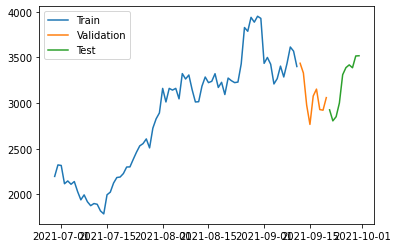

In [10]:
from matplotlib import pyplot as plt
plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)
plt.legend(["Train","Validation","Test"])
plt.show()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.leras import layers 
model=Sequential([
    layers.Input((1,1)),
    layers.LSTM(32),
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(1)])
model.complile(loss="mse",optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train,Y_train, validation_date=(X_val,Y_val),epochs=10)